# Прогнозирование количества заказов такси

## Функции

In [1]:
!pip install holidays catboost
!pip install -U pandas seaborn scikit-learn

You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /opt/anaconda3/lib/python3.7/site-packages (1.1.3)
Requirement already up-to-date: seaborn in /opt/anaconda3/lib/python3.7/site-packages (0.11.0)
Requirement already up-to-date: scikit-learn in /opt/anaconda3/lib/python3.7/site-packages (0.23.2)
You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import math
import timeit
import requests
import holidays
from urllib.parse import urlencode

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from collections import OrderedDict
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

In [5]:
LINK = "https://yadi.sk/d/Z8eyb3-vh-d5UQ"

In [6]:
def rmse(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)**0.5

In [7]:
def fit(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print("RMSE train:         ", rmse(y_train, y_train_pred))
  print("RMSE test (max=48): ", rmse(y_test, y_test_pred))

  return model, y_test_pred

In [8]:
def plot(*data, size=(20,5), legend=['train', 'test'], title='Dafault title'):
  _, ax = plt.subplots(figsize=size)
  for s in data:
    ax.plot(s)
  ax.legend(legend)
  ax.set_title(title)
  plt.show()

In [9]:
def fit_model(model, X_train, y_train, X_test, y_test, size=(20,5), slice=(100,300)):
  model_fit, predictions = fit(model, X_train, y_train, X_test, y_test)
  plot(y_test.values[slice[0]:slice[1]], predictions[slice[0]:slice[1]], size=size)
  return model_fit


In [10]:
def find_holiday(day):
  ru_holidays = holidays.Russia()
  return int(day in ru_holidays)

In [11]:
def day_part(time_stamp):
  hour = time_stamp.hour

  if hour == 23 or ( 0 <= hour < 6):
    return 'night'
  elif 6 <= hour < 12:
    return 'morning'
  elif 12 <= hour < 18:
    return 'afternoon'
  elif 18 <= hour < 23:
    return 'evening'

In [12]:
def test_model(estimator, X_train, y_train, X_test, y_test):
  train_rmse = rmse(y_train, estimator.predict(X_train))
  test_rmse = rmse(y_test, estimator.predict(X_test))
  print('Train RMSE:', train_rmse)
  print('Test  RMSE:', test_rmse)
  return (train_rmse, test_rmse)

In [13]:
def make_features(data, target, max_lag=1, rolling_size=1, rolling_func=['mean']):
  data['month'] = data.index.month
  data['day'] = data.index.day
  data['dayofweek'] = data.index.dayofweek
  data['hour'] = data.index.hour
  data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x in [6, 7] else 0)
  data['holiday'] = data.index.to_series().apply(find_holiday)
  data['day_part'] = data.index.to_series().apply(day_part)
  
  for lag in range(1, max_lag + 1):
      data['lag_{}'.format(lag)] = data[target].shift(lag)

  for func in rolling_func:
    name = 'rolling_' + func
    data[name] = data[target].shift().rolling(rolling_size).agg(func)


In [14]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [15]:
def test_split(df, target, test_size=0.3):
  train, test = train_test_split(df, shuffle=False, test_size=test_size)
  X_train = train.drop(target, axis=1)
  y_train = train[target]
  X_test = test.drop(target, axis=1)
  y_test = test[target]
  return (X_train, y_train, X_test, y_test)

## 1. Подготовка

In [16]:
taxi = pd.read_csv(get_url(LINK),parse_dates=[0], index_col=[0])

Run https://yadi.sk/d/Z8eyb3-vh-d5UQ


In [17]:
taxi.head(10) 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [18]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [19]:
print(taxi.index.is_monotonic)

True


In [20]:
taxi_hour = taxi.resample('1H').sum()
taxi_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [21]:
taxi_hour.resample('1M').sum()

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


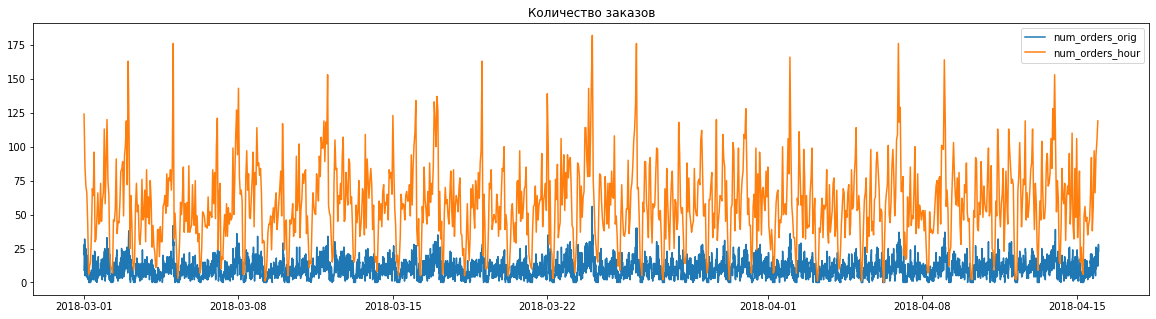

In [22]:
plot(taxi[:"2018-04-15"].num_orders, 
     taxi_hour[:"2018-04-15"].num_orders, 
     legend=['num_orders_orig','num_orders_hour'],
     title='Количество заказов'
     )

В данных 26496 наблюдений за 6 месяцев с интервалом в 10 минут. Явных пропусков нет.

## Анализ

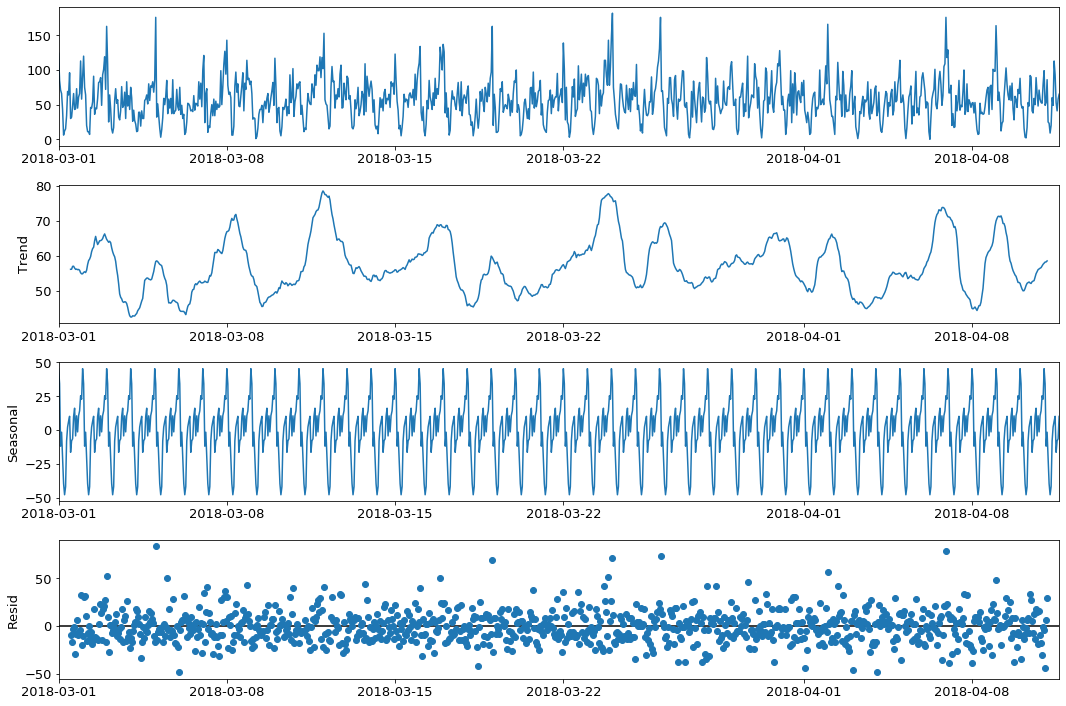

In [23]:
decomposed = seasonal_decompose(taxi_hour[:1000])

plt.rc('figure',figsize=(15,10))
plt.rc('font',size=13)
decomposed.plot();
plt.show()

In [24]:
taxi_hour["2018-03-01":"2018-03-31"].num_orders.describe()

count    744.000000
mean      57.483871
std       29.562439
min        1.000000
25%       39.000000
50%       55.000000
75%       75.000000
max      182.000000
Name: num_orders, dtype: float64

In [25]:
taxi_hour["2018-05-01":"2018-05-31"].num_orders.describe()


count    744.000000
mean      73.682796
std       34.849825
min        2.000000
25%       53.000000
50%       71.000000
75%       92.000000
max      234.000000
Name: num_orders, dtype: float64

In [26]:
taxi_hour["2018-07-01":"2018-07-31"].num_orders.describe()

count    744.00000
mean     100.00672
std       37.25477
min       11.00000
25%       76.00000
50%       98.00000
75%      122.00000
max      251.00000
Name: num_orders, dtype: float64

Из графиков и описания данных следует, что временной ряд близок к стационарному, не не является таковым:
* меняется среднее и медиана на протяжении наблюдаемого времени
* меняется стандартное отклонение.

Отмечены особеннсти:
* Тренд говорит о том, что спрос на такси повышается в течение наблюдаемого полугодия.
* У временного ряда присутствует выраженная сезонность.

Добавим признаки.

In [27]:
make_features(taxi_hour, 'num_orders', max_lag=6, rolling_size=24, rolling_func=['mean'])
taxi_hour.rename(columns={'rolling_mean':'roll_mean_24'}, inplace=True)

make_features(taxi_hour, 'num_orders', rolling_size=6, rolling_func=['mean'])
taxi_hour.rename(columns={'rolling_mean':'roll_mean_6'}, inplace=True)

taxi_hour.dropna(inplace=True)
taxi_hour.sample(5)

,num_orders,month,day,dayofweek,hour,weekend,holiday,day_part,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,roll_mean_24,roll_mean_6
datetime,,,,,,,,,,,,,,,,
2018-05-28 10:00:00,107,5,28,0,10,0,0,morning,96.0,70.0,27.0,9.0,28.0,107.0,81.916667,56.166667
2018-08-13 22:00:00,104,8,13,0,22,0,0,evening,160.0,82.0,91.0,104.0,152.0,144.0,142.541667,122.166667
2018-05-11 13:00:00,60,5,11,4,13,0,0,afternoon,48.0,84.0,83.0,66.0,60.0,14.0,65.125000,59.166667
2018-08-08 20:00:00,127,8,8,2,20,0,0,evening,96.0,58.0,95.0,196.0,85.0,80.0,107.000000,101.666667
2018-03-26 20:00:00,55,3,26,0,20,0,0,evening,58.0,29.0,48.0,92.0,86.0,33.0,68.541667,57.666667


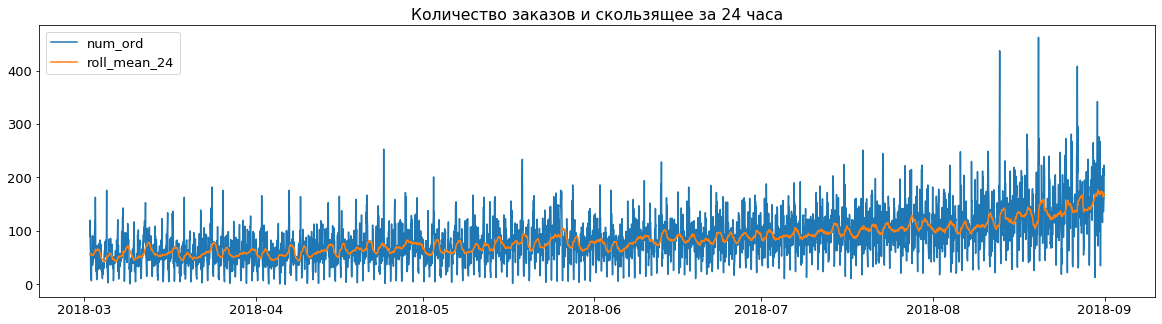

In [28]:
plot(taxi_hour.num_orders, taxi_hour.roll_mean_24, 
     title="Количество заказов и скользящее за 24 часа", 
     legend=['num_ord','roll_mean_24'])

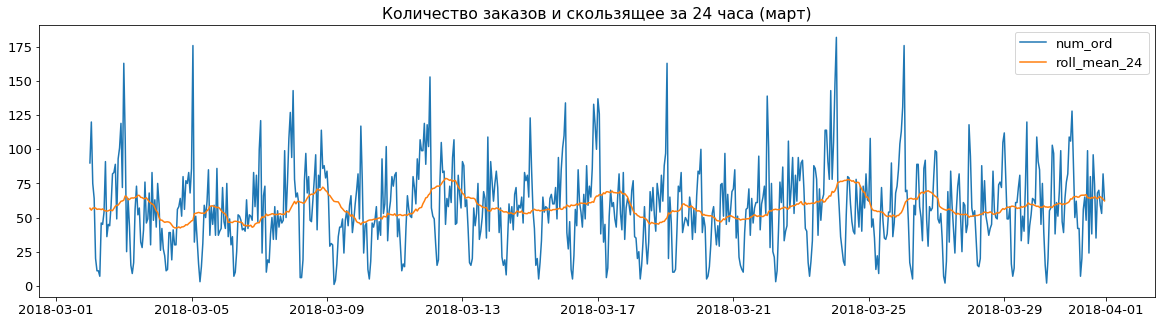

In [29]:
# посмотрим на март (есть праздники)
df = taxi_hour["2018-03-01":"2018-03-31"]
plot(df.num_orders, df.roll_mean_24, 
     title="Количество заказов и скользящее за 24 часа (март)", 
     legend=['num_ord','roll_mean_24']
     )

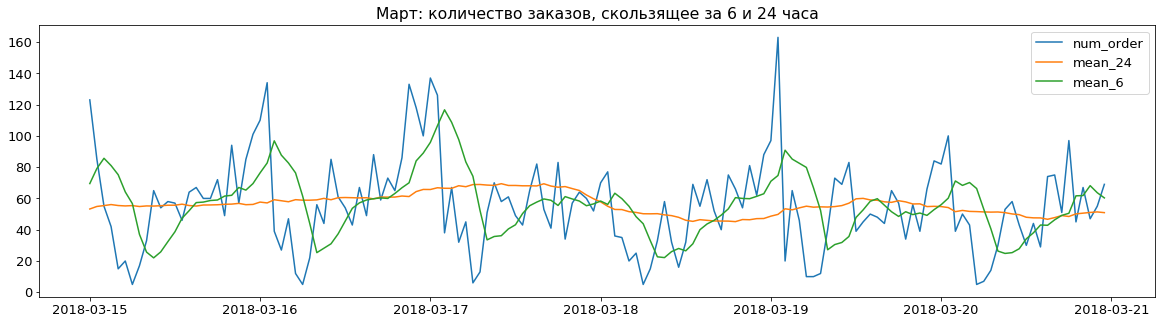

In [30]:
# посмотрим поближе на дни марта
df = taxi_hour["2018-03-15":"2018-03-20"]
plot(df.num_orders, df.roll_mean_24, df.roll_mean_6, 
     title="Март: количество заказов, скользящее за 6 и 24 часа", 
     legend=['num_order', 'mean_24', 'mean_6'])

Видно, что наблюдается периодичность значений для каждого дня. Значит, имеет значение время дня.

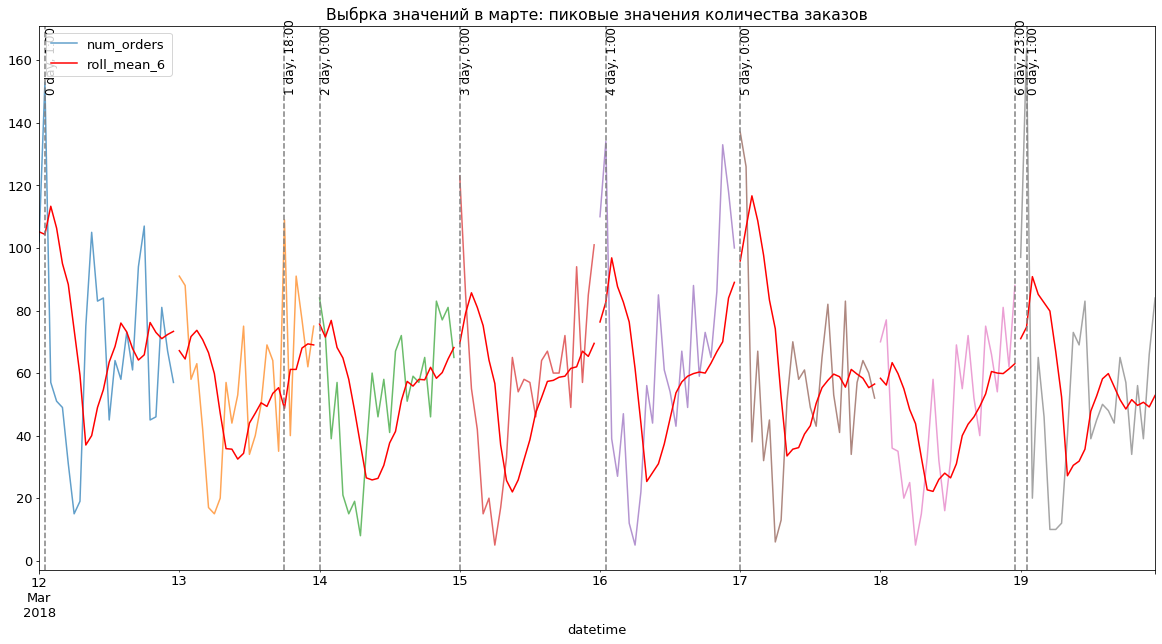

In [31]:
# посмотрим поближе на дни марта
_, ax = plt.subplots(1, figsize=(20,10))

for i in range(12, 20):
  temp = "2018-03-{} ".format(i)
  begin = temp+'00'
  end = temp+'23'
  df = taxi_hour[begin:end]

  df.num_orders.plot(ax=ax, alpha=0.7)
  df.roll_mean_6.plot(ax=ax, color='red')

  max_time = df.num_orders.idxmax()
  ax.axvline(x=max_time, linestyle='--', color='gray')
  ax.annotate('{} day, {}:00'.format(max_time.dayofweek, max_time.hour), xy=(max_time, 150), fontsize=12, rotation=90)

  ax.set_title('Выбрка значений в марте: пиковые значения количества заказов')
  ax.legend(['num_orders', 'roll_mean_6'])

plt.show()

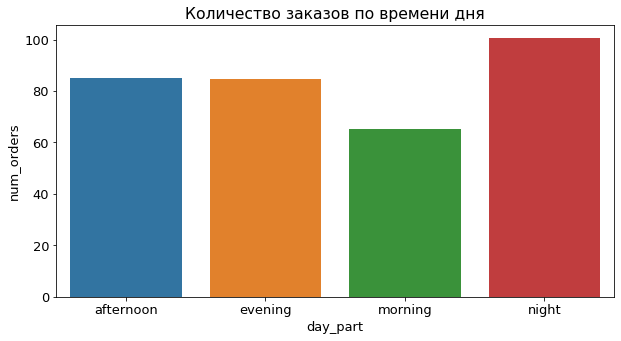

In [32]:
_, ax = plt.subplots(1, figsize=(10,5))
sns.barplot(x="day_part", 
            y="num_orders", 
            ax=ax,
            data=taxi_hour.groupby('day_part')['num_orders'].mean().reset_index());
ax.set_title('Количество заказов по времени дня')
plt.show()

### Вывод

* временной ряд близок к стационарному, не не является таковым (меняется среднее и медиана на протяжении наблюдаемого времени, меняется стандартное отклонение)
* Спрос на такси повышается в течение наблюдаемого полугодия.
* У временного ряда присутствует выраженная сезонность.
* Больше всего заказов по ночам (меньше всего - по утрам, среднее количество заказов днем и вечером)

## 3. Обучение

In [33]:
tscv = TimeSeriesSplit(n_splits=2)
X_train, y_train, X_test, y_test = test_split(taxi_hour, 'num_orders', test_size=0.1)
cat_features=['month','day','dayofweek','hour','weekend','holiday','day_part']

### CatBoost

In [34]:
%%time

params = {
    "iterations": [500, 1000],
    "depth": [3, 5],
    "l2_leaf_reg": [3., .05, .005]
}

m = CatBoostRegressor(cat_features=cat_features, verbose=False)
gsearch = GridSearchCV(m, cv=tscv, param_grid=params, scoring=make_scorer(rmse))
gsearch.fit(X_train, y_train)

print(gsearch.best_params_)
print(gsearch.best_score_)

cbr_best = gsearch.best_estimator_

print()

{'depth': 5, 'iterations': 1000, 'l2_leaf_reg': 0.005}
32.62974138760268

CPU times: user 2min 47s, sys: 17.1 s, total: 3min 4s
Wall time: 58.1 s


RMSE train:          17.082914496327927
RMSE test (max=48):  40.91884501619014


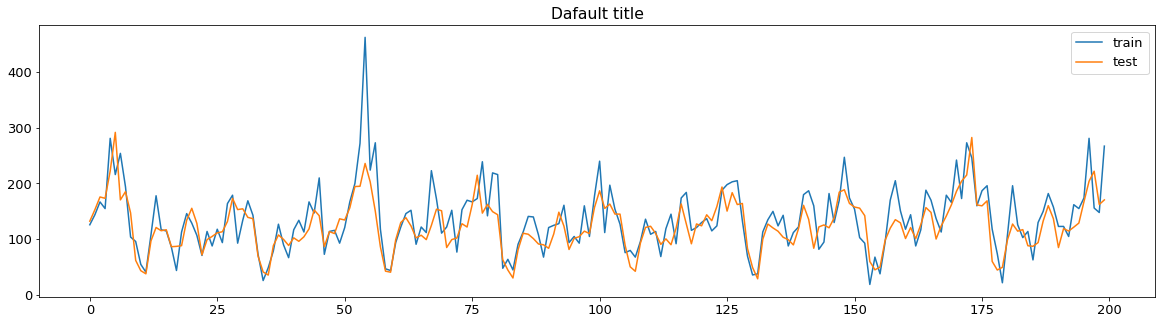

CPU times: user 16.7 s, sys: 1.24 s, total: 18 s
Wall time: 5.46 s


In [35]:
%%time

cbr = fit_model(cbr_best, X_train, y_train, X_test, y_test)

### LinearRegression

In [36]:
# подготовка данных для обучения - кодирование категориальных признаков
taxi_hour_enc = taxi_hour.copy()

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(taxi_hour_enc[['day_part']]).toarray()

enc_df = pd.DataFrame(enc.fit_transform(
    taxi_hour_enc[['day_part']]).toarray()).astype('int')
enc_df = enc_df.set_axis(enc.categories_, axis=1)
enc_df.index = taxi_hour_enc.index
taxi_hour_enc = taxi_hour_enc.join(enc_df.set_axis(enc.categories_, axis=1)).drop('day_part', axis=1)
taxi_hour_enc.head()

,num_orders,month,day,dayofweek,hour,weekend,holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,roll_mean_24,roll_mean_6,"(afternoon,)","(evening,)","(morning,)","(night,)"
datetime,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,0,0,58.0,113.0,66.0,61.0,45.0,73.0,56.833333,69.333333,0,0,0,1
2018-03-02 01:00:00,120,3,2,4,1,0,0,90.0,58.0,113.0,66.0,61.0,45.0,55.416667,72.166667,0,0,0,1
2018-03-02 02:00:00,75,3,2,4,2,0,0,120.0,90.0,58.0,113.0,66.0,61.0,56.875000,84.666667,0,0,0,1
2018-03-02 03:00:00,64,3,2,4,3,0,0,75.0,120.0,90.0,58.0,113.0,66.0,57.041667,87.000000,0,0,0,1
2018-03-02 04:00:00,20,3,2,4,4,0,0,64.0,75.0,120.0,90.0,58.0,113.0,56.958333,86.666667,0,0,0,1


In [37]:
X_train_enc, y_train, X_test_enc, y_test = test_split(taxi_hour_enc, 'num_orders', test_size=0.1)

In [38]:
%%time

params = {
    "fit_intercept": [True, False],
    "normalize": [False, True],
    "copy_X": [True, False]
}

gsearch = GridSearchCV(LinearRegression(), cv=tscv, 
                       param_grid=params, scoring=make_scorer(rmse))
gsearch.fit(X_train_enc, y_train)

print(gsearch.best_params_)
print(gsearch.best_score_)

lnr_best = gsearch.best_estimator_

print()

{'copy_X': True, 'fit_intercept': False, 'normalize': False}
32.017260849318

CPU times: user 274 ms, sys: 8.52 ms, total: 282 ms
Wall time: 359 ms


RMSE train:          29.396404278493634
RMSE test (max=48):  49.68814131932503


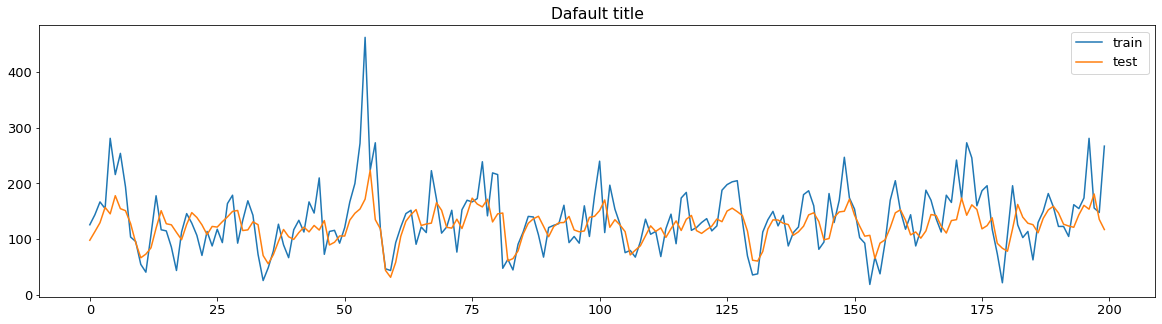

CPU times: user 518 ms, sys: 26.6 ms, total: 545 ms
Wall time: 340 ms


In [39]:
%%time

lnr = fit_model(lnr_best, X_train_enc, y_train, X_test_enc, y_test)

### Ridge

In [40]:
%%time

params = {
    "alpha": [1., 0.1, 0.01],
    "solver": ['auto','svd','cholesky','lsqr','sag', 'sparse_cg'],
    "max_iter": [100, 1000, 2000],
    "tol": [0.001, 0.01, 0.0001]
}

gsearch = GridSearchCV(Ridge(), cv=tscv, param_grid=params, scoring=make_scorer(rmse))
gsearch.fit(X_train_enc, y_train)

print(gsearch.best_params_)
print(gsearch.best_score_)

rdg_best = gsearch.best_estimator_

print()

{'alpha': 1.0, 'max_iter': 100, 'solver': 'sparse_cg', 'tol': 0.01}
33.42449196202918

CPU times: user 20.4 s, sys: 531 ms, total: 21 s
Wall time: 12.4 s


RMSE train:          30.62572178810164
RMSE test (max=48):  50.428255464921754


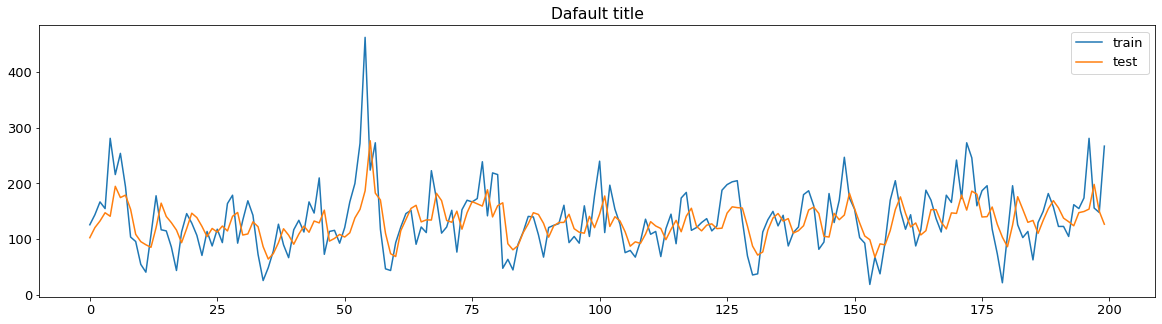

CPU times: user 509 ms, sys: 32.8 ms, total: 541 ms
Wall time: 338 ms


In [41]:
%%time

# rdg_best = Ridge(alpha=.0001, max_iter=1000, solver='sparse_cg', tol=0.00001)
rdg = fit_model(rdg_best, X_train_enc, y_train, X_test_enc, y_test)


### RandomForestRegressor

In [42]:
%%time

params = {
    "max_depth": [3, 5],
    "n_estimators": [1000],
    "min_samples_leaf": [1, 2],
}
gsearch = GridSearchCV(RandomForestRegressor(), cv=tscv, param_grid=params, scoring=make_scorer(rmse))
gsearch.fit(X_train_enc, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)

rf_best = gsearch.best_estimator_

print()

{'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 1000}
35.27767124702372

CPU times: user 48 s, sys: 76.1 ms, total: 48 s
Wall time: 48.1 s


RMSE train:          27.13675500974557
RMSE test (max=48):  61.64761890817382


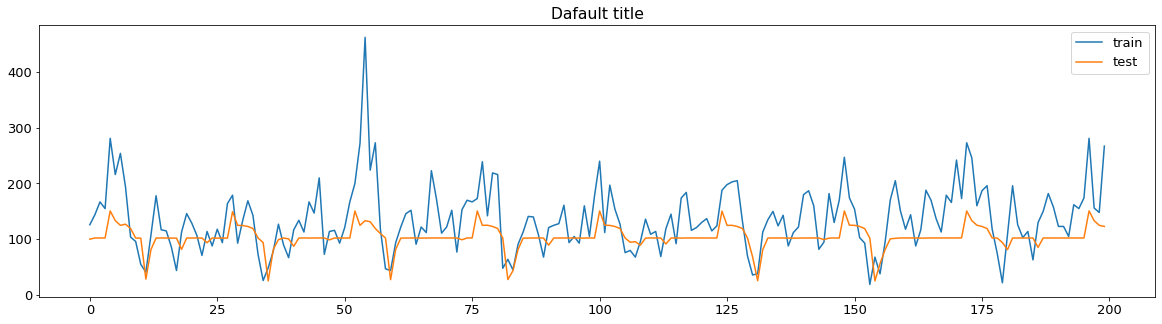

CPU times: user 7.33 s, sys: 15.2 ms, total: 7.35 s
Wall time: 7.35 s


In [43]:
%%time

rf = fit_model(rf_best, X_train_enc, y_train, X_test_enc, y_test)

### Вывод

Обчались модели:
* CatBoost
* LinearRegression
* Ridge
* RandomForest

Модель RandomForest существенно отстает по всем критериям: время обучения, метрика. Модели LinearRegression и Ridge намного быстрее обучаются (милисекунды), но метрика не укладывается в требуемые границы. CatBoost подольше обучается (~6s), но за приемлемое время и c адекватным значением метрики. Так как в рамках задачи не ставились условия относительно времени работы модели, то выбирается CatBoost

## 4. Тестирование

In [44]:
fit_predict_data = OrderedDict()

In [45]:
%%time

test_result = list(test_model(cbr, X_train, y_train, X_test, y_test))
fit_predict_data = pd.DataFrame({'CatBoost': test_result}).set_axis(['train', 'test'])

Train RMSE: 17.082914496327927
Test  RMSE: 40.91884501619014
CPU times: user 79.8 ms, sys: 0 ns, total: 79.8 ms
Wall time: 38.4 ms


In [46]:
%%time

fit_predict_data['LinearRegression'] = list(test_model(lnr, X_train_enc, y_train, X_test_enc, y_test))

Train RMSE: 29.396404278493634
Test  RMSE: 49.68814131932503
CPU times: user 21 ms, sys: 66 µs, total: 21 ms
Wall time: 12.8 ms


In [47]:
%%time

fit_predict_data['Ridge'] = list(test_model(rdg, X_train_enc, y_train, X_test_enc, y_test))

Train RMSE: 30.62572178810164
Test  RMSE: 50.428255464921754
CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 10 ms


In [48]:
%%time

fit_predict_data['RandomForest'] = list(test_model(rf, X_train_enc, y_train, X_test_enc, y_test))

Train RMSE: 27.13675500974557
Test  RMSE: 61.64761890817382
CPU times: user 423 ms, sys: 24.2 ms, total: 447 ms
Wall time: 329 ms


In [49]:
fit_predict_data

,CatBoost,LinearRegression,Ridge,RandomForest
train,17.082914,29.396404,30.625722,27.136755
test,40.918845,49.688141,50.428255,61.647619


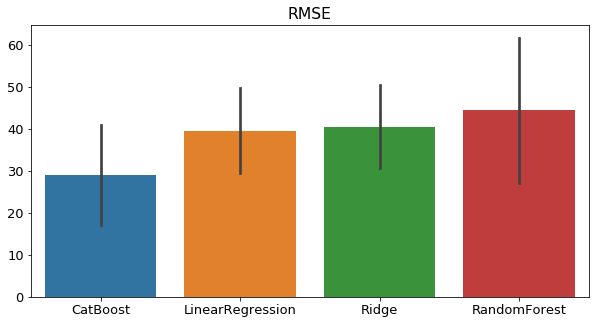

In [50]:
fig, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(data=fit_predict_data, ax=ax)
ax.set_title('RMSE')
plt.show()

## Вывод

В результате исследования выявлено, что наиболее подходящей моделью является CatBoost:
* минимальное значение метрики RMSE - ~40
* приемлемое время обучения (6s) и предсказания (40ms)

Другие модели проигрывают CatBoost по качеству и/или времени обучения и предсказания.